In [13]:
import numpy as np
import matplotlib.pyplot as plt

In [14]:
# move a cartesian robot

# this is an example of how to generate a relative motion on a stepper motor

def s(t, T):
    return 3*np.pow(t/T, 2) - 2*np.pow(t/T, 3)

x_i = np.array([0, 0, 0]) # initial position (mm)
x_f = np.array([50, 50, 50]) # final position (mm)

prev_x = x_i # previous position

f = 100 # update frequency (Hz) need to lower is is the step are to small 
T = 5 # time of the motion (s)

rev_motor = np.array([0, 0, 0]) # output revolution command for the motors

# convert the motion of the end effector (mm/s) to the revolution of the motors (rev/s)
Inv_Jacobian = np.array([[1/(20*3), 0,        0],    # Motor 1 (pulley with 20 teeth, belt with 3mm pitch) 1/t*p
                         [0,        1/(20*3), 0],    # Motor 2 (pulley with 20 teeth, belt with 3mm pitch) 1/t*p
                         [0,        0,        1/2]]) # Motor 3 (lead screw with 2mm pitch) 1/p

cmd_motor = {}
pose_end_effector = {}

for t in range(1, int(f * T)):

    x = x_i + (x_f - x_i) * s(t, f * T)
    delta_x = x - prev_x

    rev_motor = np.dot(Inv_Jacobian, x) * 60 # also convert to revolutions per minute (rpm)
    speed_motor = np.dot(Inv_Jacobian, f *  (delta_x)) # so the update rate is constant

    print(f"Motor rev: {rev_motor}, speed: {speed_motor}")
    print(f"End effector position: {delta_x}, speed: {f * delta_x}")

    # store the revolution (rev) and speed (rev/s)
    cmd_motor[t - 1] = {
        "rev": [rev_motor[0], rev_motor[1], rev_motor[2]],
        "speed": [speed_motor[0], speed_motor[1], speed_motor[2]]
    }

    # store the motion of the end effector: position (mm) and speed (mm/s)
    pose_end_effector[t - 1] = {
        "position": [x[0], x[1], x[2]],
        "speed": [f * delta_x[0], f * delta_x[1], f * delta_x[2]]
    }

    prev_x = x

Motor rev: [0.0005992 0.0005992 0.017976 ], speed: [0.00099867 0.00099867 0.02996   ]
End effector position: [0.0005992 0.0005992 0.0005992], speed: [0.05992 0.05992 0.05992]
Motor rev: [0.0023936 0.0023936 0.071808 ], speed: [0.00299067 0.00299067 0.08972   ]
End effector position: [0.0017944 0.0017944 0.0017944], speed: [0.17944 0.17944 0.17944]
Motor rev: [0.0053784 0.0053784 0.161352 ], speed: [0.00497467 0.00497467 0.14924   ]
End effector position: [0.0029848 0.0029848 0.0029848], speed: [0.29848 0.29848 0.29848]
Motor rev: [0.0095488 0.0095488 0.286464 ], speed: [0.00695067 0.00695067 0.20852   ]
End effector position: [0.0041704 0.0041704 0.0041704], speed: [0.41704 0.41704 0.41704]
Motor rev: [0.0149 0.0149 0.447 ], speed: [0.00891867 0.00891867 0.26756   ]
End effector position: [0.0053512 0.0053512 0.0053512], speed: [0.53512 0.53512 0.53512]
Motor rev: [0.0214272 0.0214272 0.642816 ], speed: [0.01087867 0.01087867 0.32636   ]
End effector position: [0.0065272 0.0065272 0.00

In [15]:
# Convert the relative motion into commands
command_lines = []

# first add homing 
# command_lines.append(f"HIT x,0,y,0,z,0")

for t in cmd_motor:
    row = cmd_motor[t]

    speed_cmd = f"SPEED x,{row['speed'][0]},y,{row['speed'][1]},z,{row['speed'][2]}"
    move_cmd = f"POSITION x,{row['rev'][0]},y,{row['rev'][1]},z,{row['rev'][2]}"

    command_lines.append(speed_cmd)
    command_lines.append(move_cmd)

# Save to file
with open("motor_commands.txt", "w") as f:
    for line in command_lines:
        f.write(line + "\n")

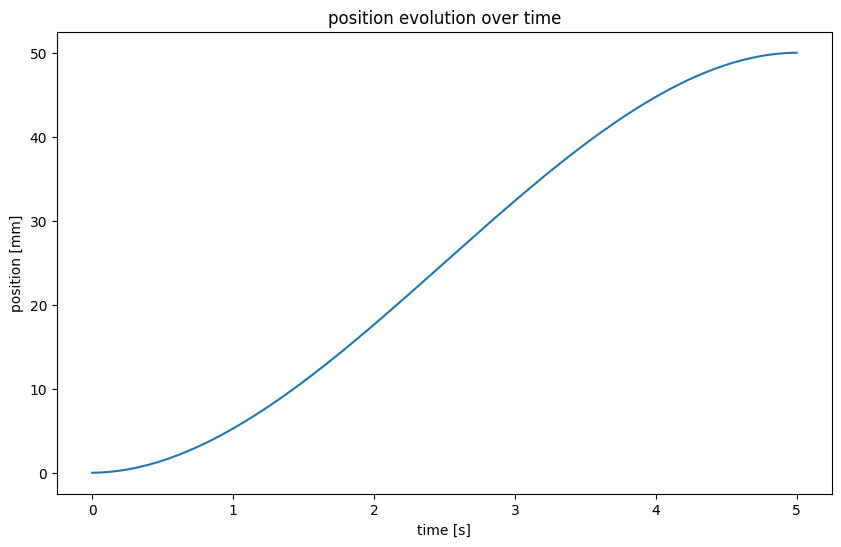

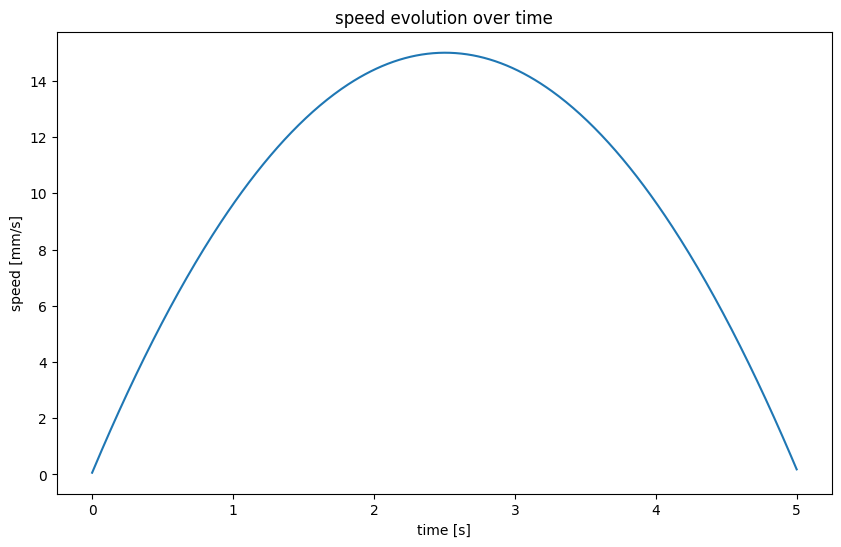

In [16]:
num_points = len(pose_end_effector)

move = np.array([pose_end_effector[t]["position"][0] for t in range(num_points)])
speed = np.array([pose_end_effector[t]["speed"][0] for t in range(num_points)])

t_values = np.linspace(0, T, len(move))

# plot the relative motion of the end effector
plt.figure(figsize=(10, 6))
plt.plot(t_values, move, label='Position [mm]')
plt.xlabel("time [s]")
plt.ylabel("position [mm]")
plt.title("position evolution over time")
plt.show()

# plot the speed of the end effector
plt.figure(figsize=(10, 6))
plt.plot(t_values, speed, label='Speed [mm/s]')
plt.xlabel("time [s]")
plt.ylabel("speed [mm/s]")
plt.title("speed evolution over time")
plt.show()